# Predicting CLTV and Customer Repeat with Machine Learning for Shopify 

#### A Data Science Analysis Project by Benjamin N. Bellman 

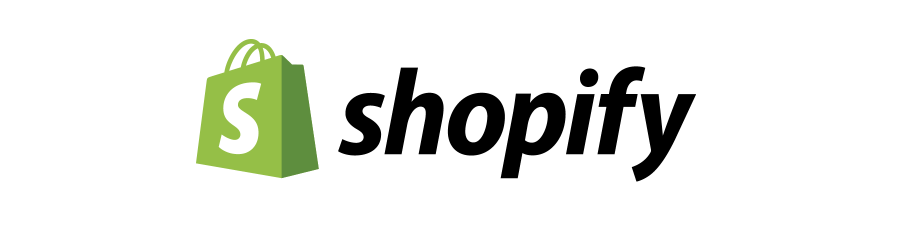

### Project Table of Contents: 
<br> 
    
**I. INTRODUCTION \& PRELIMINARY ANALYSIS**
- 1. Project Purpose 
- 2. Loading \& Previewing Data   
- 3. Data Wrangling  
- 4. Preliminary EDA 
 
**II. DATA WRANGLING**  
- 1. Cleaning up data. 
- 2. Creating 3 separate dataframes.
- 3. Creating the final 1 year CLTV Table.

**III. EXPLORATORY DATA ANALYSIS**     
- 1. Loading an Previewing the New Table  
- 2. Exploring relationships of variables on Post First Week Spend 

**IV. PREPROCESSING AND MODELLING**
- 1. Linear Models
- 2. Classification Models


## Part 3: PreProcessing and Modelling

### Loading our Packages and DataFrame

In [1]:
## We start by importing the packages we will use.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.graphics.api import abline_plot 

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor, GradientBoostingClassifier

from sklearn.metrics import precision_recall_curve, roc_curve, auc, confusion_matrix, accuracy_score, precision_score
from sklearn.metrics import mean_squared_error as mse, r2_score, mean_absolute_error as mae, f1_score, fbeta_score 
from sklearn.metrics import plot_confusion_matrix,classification_report, balanced_accuracy_score, recall_score
from sklearn.metrics import roc_auc_score

from io import StringIO 
from IPython.display import Image  
import pydotplus
import graphviz

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
pd.set_option('display.max_columns', None)

In [2]:
## We Load and preview our customer_cltv dataframe from the previouse chapter 
customer_cltv = pd.read_csv('.\..\cleaned_data.csv',index_col=0)
customer_cltv.head()

,CustomerID,pfw_spent,fw_nb_orders,fw_nb_items,fw_total_spent,fw_used_coupon,first_order_month,fw_purchased_accessory,first_item_size,accepts_marketing,wealthy_zip,region,first_item_price_range
0,Anonymous13455,1257.80,1,1,50.0,0,6,0,M,0,0,MW,high
1,Anonymous2142,436.15,1,1,48.0,0,5,0,L,0,0,NE,high
2,Anonymous4843,1052.75,2,2,96.0,0,10,0,S,1,0,W,high
3,Anonymous11225,728.10,1,1,16.0,0,1,1,No size,0,0,MW,low
4,Anonymous540,1114.75,1,1,50.0,0,1,0,XS,0,0,W,high


## Preprocessing: 

In [3]:
## Drop some error rows (no spending on the first week)
customer_cltv = customer_cltv[customer_cltv.loc[:,'fw_total_spent'] > 0] 

## Drop all non-repeat customers
#customer_cltv_drop = customer_cltv_drop[customer_cltv.loc[:,'pfw_spent'] > 0]

In [4]:
## We change the pfw_spent column and create a new target column: repeat
customer_cltv['repeat'] = np.where(customer_cltv['pfw_spent'] > 0,1,0)
customer_cltv.drop(columns='pfw_spent',inplace=True)
customer_cltv.head()

,CustomerID,fw_nb_orders,fw_nb_items,fw_total_spent,fw_used_coupon,first_order_month,fw_purchased_accessory,first_item_size,accepts_marketing,wealthy_zip,region,first_item_price_range,repeat
0,Anonymous13455,1,1,50.0,0,6,0,M,0,0,MW,high,1
1,Anonymous2142,1,1,48.0,0,5,0,L,0,0,NE,high,1
2,Anonymous4843,2,2,96.0,0,10,0,S,1,0,W,high,1
3,Anonymous11225,1,1,16.0,0,1,1,No size,0,0,MW,low,1
4,Anonymous540,1,1,50.0,0,1,0,XS,0,0,W,high,1


<br> **Drop variables that we found to be heavily correlated with other or irrelevant through the previous step of EDA**
- **fw_nb_items** is highly correlated with fw_total_spent (c=0.94)
- **fw_nb_orders** is very unbalanced (~ 95% customers only made 1 order the first week)
- **region** was found to be insignificant based on several steps of statistical analysis
- **fw_purchased_accessory** is logically redundant with first_item_size


In [5]:
customer_cltv.drop(columns=['fw_nb_items', 'region', 'fw_nb_orders', 'fw_purchased_accessory'], inplace = True)

<br> **Modify variables based on findings from EDA**
- **first_order_month** can be modified to be 2 categories: February-June vs rest of the year
- **first_item size** can be modified to be 2 categories: Large Size and Smaller Sizes

In [6]:
## First Item Month 
customer_cltv['first_order_feb_june'] = customer_cltv['first_order_month'].apply(lambda x: x in [2, 3, 4, 5, 6])
customer_cltv['first_order_feb_june'].replace({True:1,False:0}, inplace = True)
customer_cltv.drop(columns=['first_order_month'], inplace = True)

## First Item Size: 
customer_cltv['large_size'] = customer_cltv['first_item_size'].apply(lambda x: x in ['XL','L','M'])
customer_cltv['large_size'].replace({True:1,False:0}, inplace = True)
customer_cltv.drop(columns=['first_item_size'], inplace = True)
customer_cltv.head()

,CustomerID,fw_total_spent,fw_used_coupon,accepts_marketing,wealthy_zip,first_item_price_range,repeat,first_order_feb_june,large_size
0,Anonymous13455,50.0,0,0,0,high,1,1,1
1,Anonymous2142,48.0,0,0,0,high,1,1,1
2,Anonymous4843,96.0,0,1,0,high,1,0,0
3,Anonymous11225,16.0,0,0,0,low,1,0,0
4,Anonymous540,50.0,0,0,0,high,1,0,0


#### We create dummy variables for our categorical variables.

In [7]:
## We create dummy variables for prize range of items. 
categorical_cols = ['first_item_price_range']
dummies_encoded = pd.get_dummies(customer_cltv[categorical_cols].astype(str),drop_first=True)
customer_cltv = pd.concat([customer_cltv,dummies_encoded], axis =1)
customer_cltv.drop(columns=['first_item_price_range'],inplace = True)
customer_cltv.head()

,CustomerID,fw_total_spent,fw_used_coupon,accepts_marketing,wealthy_zip,repeat,first_order_feb_june,large_size,first_item_price_range_low,first_item_price_range_medium
0,Anonymous13455,50.0,0,0,0,1,1,1,0,0
1,Anonymous2142,48.0,0,0,0,1,1,1,0,0
2,Anonymous4843,96.0,0,1,0,1,0,0,0,0
3,Anonymous11225,16.0,0,0,0,1,0,0,1,0
4,Anonymous540,50.0,0,0,0,1,0,0,0,0


In [8]:
## We get our feature variables and target variables
X = customer_cltv.drop(columns=['CustomerID','repeat'])
y = customer_cltv['repeat']
print(X.shape, y.shape)

(10590, 8) (10590,)


In [9]:
## We use a scaler to scale the feature variables which are not categorical: 
cols_to_scale = ['fw_total_spent']
scaler = StandardScaler()
scaler.fit(X[cols_to_scale])

X_scaled = scaler.transform(X[cols_to_scale])
for ind, col in enumerate(cols_to_scale):
    X[col] = X_scaled[:,ind]
X.head()

,fw_total_spent,fw_used_coupon,accepts_marketing,wealthy_zip,first_order_feb_june,large_size,first_item_price_range_low,first_item_price_range_medium
0,-0.347324,0,0,0,1,1,0,0
1,-0.389530,0,0,0,1,1,0,0
2,0.623424,0,1,0,0,0,0,0
3,-1.064833,0,0,0,0,0,1,0
4,-0.347324,0,0,0,0,0,0,0


In [10]:
## We split our data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(7942, 8) (2648, 8) (7942,) (2648,)


# Classification Models
<br> In the previous models, our target feature was **continuous**. We will be treating pwf as a **discrete**.
<br> **We will be using 7 different classification models:**
- 1) Logistic Regression 
- 2) Random Forests
- 3) Gradient Boosting
- 4) SVC 
- 5) K-NN
- 6) Naive Bayes
- 7) Stochastic Gradient Descent

## 1) Logistic Regression 

In [11]:
## With the best parameters, we re-instantiate the model, fit and predict the probabilities. 
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

## We predict the probabilities of s
y_pred_log_reg = log_reg.predict(X_test)
y_pred_log_reg = pd.Series(y_pred_log_reg )

## We visualize the prediction that the Logistic Regression Gives us. 
y_pred_log_reg.value_counts()

0    2629
1      19
dtype: int64

In [12]:
## We instantiate a logistic regression model and use GridSearchCV to find the best parameters. 
log_reg = LogisticRegression()
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
             'l1_ratio': [0,.5,1],
             'penalty':['none','l1','l2','elasticnet']
             }
lr_cv = GridSearchCV(log_reg, param_grid, cv=10, scoring='roc_auc')
lr_cv.fit(X_train,y_train)

## We print the metrics: 
print('Best Estimator:' +str(lr_cv.best_estimator_))
print('Best Params:' +str(lr_cv.best_params_))
print('Best Score:' +str(lr_cv.best_score_))

Best Estimator:LogisticRegression(C=0.01, l1_ratio=0)
Best Params:{'C': 0.01, 'l1_ratio': 0, 'penalty': 'l2'}
Best Score:0.5954477808783644


In [13]:
## With the best parameters, we re-instantiate the model, fit and predict the outcomes. 
best_lreg = LogisticRegression(C = 0.01, l1_ratio= 0, penalty = 'l2')
best_lreg.fit(X_train, y_train)

## We predict on the test data. 
y_pred_best_lreg = best_lreg.predict(X_test)

Accuracy Score: 0.724320241691843
Precision Score: 0.6470588235294118
Recall Score: 0.014965986394557823
F1 Score: 0.029255319148936167


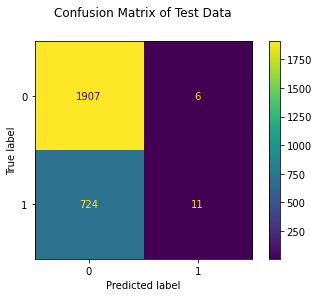

In [14]:
## We define and print out some metrics. 
accuracy_log  = accuracy_score(y_test,y_pred_best_lreg)
precision_log = precision_score(y_test,y_pred_best_lreg)
recall_log = recall_score(y_test,y_pred_best_lreg)
f1_log = f1_score(y_test,y_pred_best_lreg)
print("Accuracy Score: " + str(accuracy_log))
print("Precision Score: " +str(precision_log))
print("Recall Score: " +str(recall_log))
print("F1 Score: " +str(f1_log))

## We plot the confusion Matrix to visualize the predictions
plot_confusion_matrix(best_lreg, X_test,y_test)
plt.title('Confusion Matrix of Test Data', pad =25)
plt.show()


## 2 Random Forests:

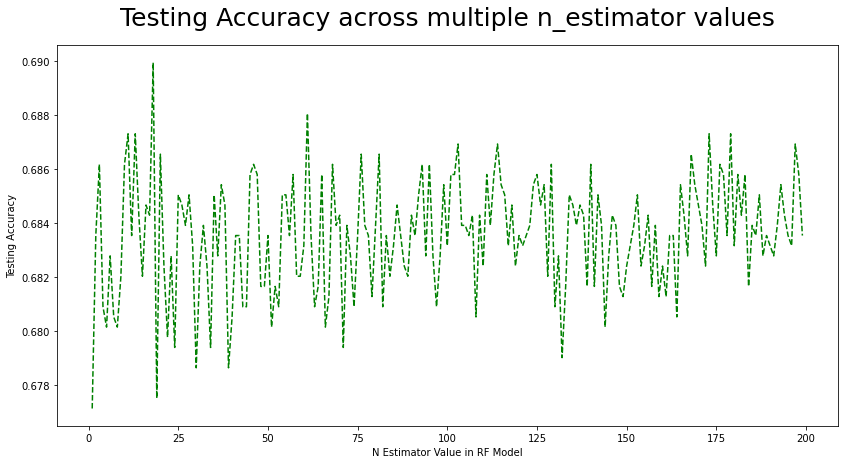

In [15]:
## Prior to using GridSeachCV, we can see the effect of n_estimators on testing accuracy. 
scores =[]
for k in range(1, 200):
    rfc = RandomForestClassifier(n_estimators=k)
    rfc.fit(X_train, y_train)
    y_pred_rf = rfc.predict(X_test)
    scores.append(accuracy_score(y_test, y_pred_rf))

# plot the relationship between K and testing accuracy
plt.figure(figsize=(14,7))
plt.plot(range(1, 200), scores, color ='g', linestyle ='--')
plt.xlabel('N Estimator Value in RF Model')
plt.ylabel('Testing Accuracy')
plt.title('Testing Accuracy across multiple n_estimator values', fontsize = 25, pad =20)
plt.show()
## Code inspired from: https://stackoverflow.com/questions/60768008/how-to-choose-n-estimators-in-randomforestclassifier

In [16]:
## We use GridSearchCV to find the best hyperparameters of RandomForest. 
'''
rfc = RandomForestClassifier(random_state = 42)
param_grid = { 
    'n_estimators': [10, 25, 50, 100, 200],
    'max_features': ['sqrt', 'auto', 'log2'],
    'criterion': ['gini','entropy'],
    'max_depth' : [2,4,6,8],
    'bootstrap':['False', 'True']
}

rfc_GS = GridSearchCV(rfc, param_grid, cv=5, scoring='roc_auc')
rfc_GS.fit(X_train,y_train)

##Let's look at the results  for Grid Search CV 
print('Best Estimator:' +str(rfc_GS.best_estimator_))
print('Best Params:' +str(rfc_GS.best_params_))
print('Best Score:' +str(rfc_GS.best_score_))
'''

## The findings for the above is as follows below: 

'''
Best Estimator:RandomForestClassifier(bootstrap='False', max_depth=4, max_features='sqrt',
                       n_estimators=50, random_state=42)
Best Params:{'bootstrap': 'False', 'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 50}
Best Score:0.5988629677995277
'''

"\nBest Estimator:RandomForestClassifier(bootstrap='False', max_depth=4, max_features='sqrt',\n                       n_estimators=50, random_state=42)\nBest Params:{'bootstrap': 'False', 'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 50}\nBest Score:0.5988629677995277\n"

In [17]:
## With the best parameters, we re-instantiate the model, fit and predict the probabilities. 
rfc_best = RandomForestClassifier(bootstrap= False, criterion= 'gini', max_depth= 4, 
                                  max_features= 'sqrt', n_estimators= 50, random_state = 42)
rfc_best.fit(X_train, y_train)
y_pred_best_rfc = rfc_best.predict(X_test)

Accuracy Score: 0.7224320241691843
Precision Score: 0.0
Recall Score: 0.0
F1 Score: 0.0


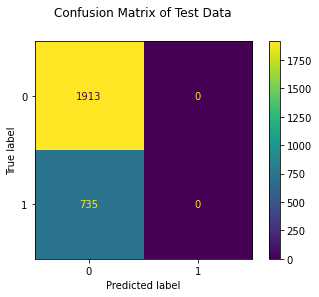

In [18]:
## We define our metrics and print them out.
accuracy_best_rfc  = accuracy_score(y_test,y_pred_best_rfc)
precision_best_rfc = precision_score(y_test,y_pred_best_rfc)
recall_best_rfc = recall_score(y_test,y_pred_best_rfc)
f1_best_rfc = f1_score(y_test,y_pred_best_rfc)
print("Accuracy Score: " + str(accuracy_best_rfc ))
print("Precision Score: " +str(precision_best_rfc))
print("Recall Score: " +str(recall_best_rfc))
print("F1 Score: " +str(f1_best_rfc))

## We plot the confusion Matrix to visualize the predictions
plot_confusion_matrix(rfc_best, X_test,y_test)
plt.title('Confusion Matrix of Test Data', pad =25)
plt.show()

In [19]:
## We can see the feature importances in the model below...
features_best = pd.DataFrame(rfc_best.feature_importances_, index = X_train.columns, 
                      columns=['importance']).sort_values('importance', ascending=False)
features_best

,importance
fw_total_spent,0.521267
first_order_feb_june,0.190310
large_size,0.129377
first_item_price_range_low,0.060412
fw_used_coupon,0.032608
accepts_marketing,0.030929
wealthy_zip,0.022596
first_item_price_range_medium,0.012501


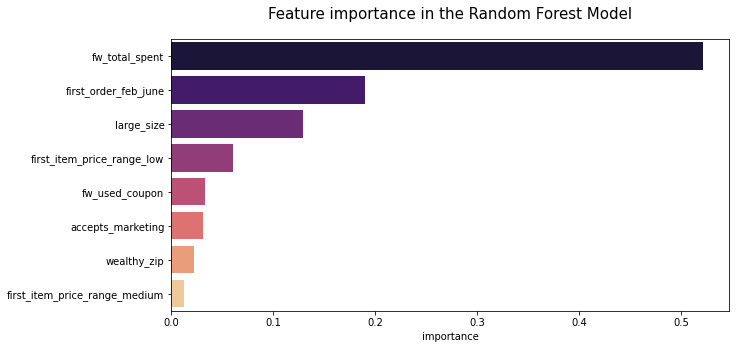

In [20]:
## ... and we can plot them. 
plt.figure(figsize=(10,5))
sns.color_palette("magma", as_cmap=True)
sns.barplot(y = features_best.index, x = features_best['importance'],palette='magma')
plt.title('Feature importance in the Random Forest Model', pad = 20, fontsize = 15)
plt.show()

## 3) Gradient Boosting:

In [21]:
## We use GridSearchCV to find the best hyperparameters for Gradient Boosting

'''
gbc = GradientBoostingClassifier(random_state = 42)
param_grid = { 
    'loss': ['exponential','deviance'],
    'n_estimators': [1,2,5,10,20,100],
    'criterion': ['friedman_mse', 'squared_error', 'mse', 'mae'],
    'max_depth' : [2,6,8,10],
}

gbc_GS = GridSearchCV(gbc, param_grid, cv=5, scoring='roc_auc')
gbc_GS.fit(X_train,y_train)

##Let's look at the results  for Grid Search CV 
print('Best Estimator:' +str(gbc_GS.best_estimator_))
print('Best Params:' +str(gbc_GS.best_params_))
print('Best Score:' +str(gbc_GS.best_score_))

'''
## The findings for the above is as follows below: 
'''
Best Estimator:GradientBoostingClassifier(loss='exponential', max_depth=2, n_estimators=20, random_state=42)
Best Params:{'criterion': 'friedman_mse', 'loss': 'exponential', 'max_depth': 2, 'n_estimators': 20}
Best Score:0.5972483890365966
'''

"\nBest Estimator:GradientBoostingClassifier(loss='exponential', max_depth=2, n_estimators=20, random_state=42)\nBest Params:{'criterion': 'friedman_mse', 'loss': 'exponential', 'max_depth': 2, 'n_estimators': 20}\nBest Score:0.5972483890365966\n"

In [22]:
## We  fit the Predictor.
gbc_best = GradientBoostingClassifier(criterion= 'friedman_mse', max_depth= 2, 
                                      max_features= 'sqrt', n_estimators= 20, loss ='exponential',
                                      random_state = 42)
gbc_best.fit(X_train, y_train)
y_pred_best_gbc = gbc_best.predict(X_test)

Accuracy Score: 0.7224320241691843
Precision Score: 0.0
Recall Score: 0.0
F1 Score: 0.0


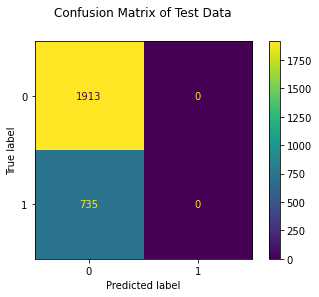

In [23]:
## We define our metrics and print them out. 
accuracy_gbc  = accuracy_score(y_test,y_pred_best_gbc)
precision_gbc = precision_score(y_test,y_pred_best_gbc)
recall_gbc = recall_score(y_test,y_pred_best_gbc)
f1_gbc = f1_score(y_test,y_pred_best_gbc)
print("Accuracy Score: " + str(accuracy_gbc))
print("Precision Score: " +str(precision_gbc))
print("Recall Score: " +str(recall_gbc))
print("F1 Score: " +str(f1_gbc))

## We plot the confusion Matrix
plot_confusion_matrix(gbc_best, X_test,y_test)
plt.title('Confusion Matrix of Test Data', pad =25)
plt.show()

## 4) SVC

In [24]:
## We use GridSearch to get the best parameters for SVC
'''
svc = SVC(random_state = 42)
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']
             }

svc_GS = GridSearchCV(svc, param_grid, scoring='roc_auc')
svc_GS.fit(X_train,y_train)

##Let's look at the results  for Grid Search CV 
print('Best Estimator:' +str(svc_GS.best_estimator_))
print('Best Params:' +str(svc_GS.best_params_))
print('Best Score:' +str(svc_GS.best_score_))
'''

## This is the result of GridSearchCV (takes close to 30 min to run): 
'''
Best Estimator:SVC(C=0.1, gamma=0.0001, random_state=42)
Best Params:{'C': 0.1, 'gamma': 0.0001, 'kernel': 'rbf'}
Best Score:0.5905049897034444
'''

"\nBest Estimator:SVC(C=0.1, gamma=0.0001, random_state=42)\nBest Params:{'C': 0.1, 'gamma': 0.0001, 'kernel': 'rbf'}\nBest Score:0.5905049897034444\n"

Accuracy Score: 0.7224320241691843
Precision Score: 0.0
Recall Score: 0.0


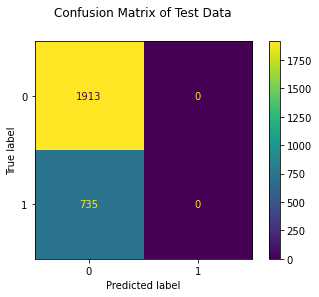

In [25]:
## We re-instantiate SVC with the best parameters.
svc_best = SVC(C=0.1, gamma=0.0001, kernel = 'rbf',random_state = 42, probability = True)
svc_best.fit(X_train, y_train)
y_pred_best_svc = svc_best.predict(X_test)

## We define our metrics and print them out. 
accuracy_best_svc = accuracy_score(y_test,y_pred_best_svc)
precision_best_svc = precision_score(y_test,y_pred_best_svc)
recall_best_svc = recall_score(y_test,y_pred_best_svc)
print("Accuracy Score: " +str(accuracy_best_svc))
print("Precision Score: " +str(precision_best_svc))
print("Recall Score: " +str(recall_best_svc))

## We plot the confusion Matrix: 
plot_confusion_matrix(svc_best, X_test,y_test)
plt.title('Confusion Matrix of Test Data', pad =25)
plt.show()

## 5) K-Nearest Neighbors

In [26]:
## We useGridSearch to get the best knn hyperparameters
'''
knn = KNeighborsClassifier()
k_range  = list(range(1,20))

parameters_KNN = {
    'n_neighbors': list(range(1,31)),
    'leaf_size': (20,40,1),
    'p': (1,2),
    'weights': ('uniform', 'distance'),
    'metric': ('minkowski', 'chebyshev')
     }

knn_GS = GridSearchCV(knn, parameters_KNN, cv=10, scoring='roc_auc', return_train_score=False, verbose=1)
knn_GS.fit(X_train,y_train)

print('Best Estimator:' +str(knn_GS.best_estimator_))
print('Best Params:' +str(knn_GS.best_params_))
print('Best Score:' +str(knn_GS.best_score_))
'''

## Results of GridSearch CV:  
'''
Best Estimator:KNeighborsClassifier(leaf_size=40, n_neighbors=25)
Best Params:{'leaf_size': 40, 'metric': 'minkowski', 'n_neighbors': 25, 'p': 2, 'weights': 'uniform'}
Best Score:0.5829836917334532
'''

"\nBest Estimator:KNeighborsClassifier(leaf_size=40, n_neighbors=25)\nBest Params:{'leaf_size': 40, 'metric': 'minkowski', 'n_neighbors': 25, 'p': 2, 'weights': 'uniform'}\nBest Score:0.5829836917334532\n"

Accuracy Score: 0.7043051359516617
Precision Score: 0.3
Recall Score: 0.04897959183673469


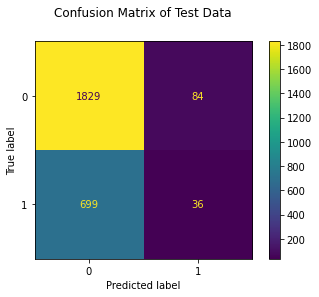

In [27]:
## We re-instantiate with the best parameters. 
knn_best = KNeighborsClassifier(leaf_size= 40, metric= 'minkowski', n_neighbors= 25, p= 2, weights= 'uniform')
knn_best.fit(X_train,y_train)
y_pred_knn_best = knn_best.predict(X_test)

accuracy_knn_best = accuracy_score(y_test,y_pred_knn_best)
precision_knn_best = precision_score(y_test,y_pred_knn_best)
recall_knn_best = recall_score(y_test,y_pred_knn_best)
print("Accuracy Score: " +str(accuracy_knn_best))
print("Precision Score: " +str(precision_knn_best))
print("Recall Score: " +str(recall_knn_best))

plot_confusion_matrix(knn_best, X_test,y_test)
plt.title('Confusion Matrix of Test Data', pad =25)
plt.show()

## 6) Naive Bayes

In [28]:
## We use GridSearch CV to get the best parameters to maximize the roc_auc
nb = GaussianNB()
params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}
nb_GS = GridSearchCV(nb, param_grid = params_NB , cv=10, scoring='roc_auc', return_train_score=False, verbose=1)
nb_GS.fit(X_train,y_train)

## We print out the result
print('Best Estimator:' +str(nb_GS.best_estimator_))
print('Best Params:' +str(nb_GS.best_params_))
print('Best Score:' +str(nb_GS.best_score_))

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Best Estimator:GaussianNB(var_smoothing=1.0)
Best Params:{'var_smoothing': 1.0}
Best Score:0.592065056294355


Accuracy Score: 0.724320241691843
Precision Score: 0.6
Recall Score: 0.02040816326530612


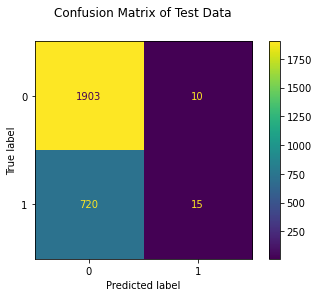

In [29]:
## We refit the model with the best parameters found above. 
nb_best = GaussianNB(var_smoothing=1.0)
nb_best.fit(X_train,y_train)
y_pred_nb_best = nb_best.predict(X_test)

## We define accuracy metrics 
accuracy_nb_best = accuracy_score(y_test,y_pred_nb_best)
precision_nb_best = precision_score(y_test,y_pred_nb_best)
recall_nb_best = recall_score(y_test,y_pred_nb_best)

## And print out the results. 
print("Accuracy Score: " +str(accuracy_nb_best))
print("Precision Score: " +str(precision_nb_best))
print("Recall Score: " +str(recall_nb_best))

## And plot the confusion Matrix. 
plot_confusion_matrix(nb_best, X_test,y_test)
plt.title('Confusion Matrix of Test Data', pad =25)
plt.show()

## 7) Stochastic Gradient Descent

In [30]:
## We use GridSearchCV to find the best parameters to maximize roc_auc. 
sgd = SGDClassifier(random_state = 42)
param_grid = {
    'loss': ['log'],
    'penalty': ['elasticnet'],
    'alpha': [10 ** x for x in range(-6, 1)],
    'l1_ratio': [0, 0.05, 0.1, 0.2, 0.5, 0.8, 0.9, 0.95, 1]
}

sgd_GS = GridSearchCV(sgd, param_grid=param_grid, n_jobs=-1, scoring='roc_auc')
sgd_GS.fit(X_train,y_train)

## We print out thr results. 
print('Best Estimator:' +str(sgd_GS.best_estimator_))
print('Best Params:' +str(sgd_GS.best_params_))
print('Best Score:' +str(sgd_GS.best_score_))

Best Estimator:SGDClassifier(alpha=0.001, l1_ratio=0.05, loss='log', penalty='elasticnet',
              random_state=42)
Best Params:{'alpha': 0.001, 'l1_ratio': 0.05, 'loss': 'log', 'penalty': 'elasticnet'}
Best Score:0.5944120529635953


Accuracy Score: 0.7224320241691843
Precision Score: 0.5
Recall Score: 0.00816326530612245


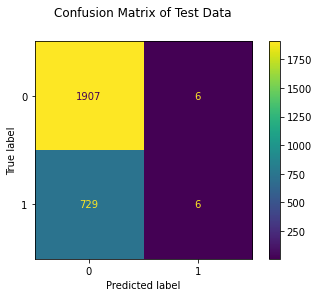

In [31]:
## We fit the SGDClassifier with the best parameters found above. 
sgd_best = SGDClassifier(alpha= 0.001, l1_ratio= 0.05, loss = 'log', penalty = 'elasticnet', random_state = 42)
sgd_best.fit(X_train,y_train)
y_pred_sgd_best = sgd_best.predict(X_test)

## We define our metrics and print out the results
accuracy_sgd_best = accuracy_score(y_test,y_pred_sgd_best)
precision_sgd_best = precision_score(y_test,y_pred_sgd_best)
recall_sgd_best = recall_score(y_test,y_pred_sgd_best)
print("Accuracy Score: " +str(accuracy_sgd_best))
print("Precision Score: " +str(precision_sgd_best))
print("Recall Score: " +str(recall_sgd_best))

## We plot the confusion_matrix
plot_confusion_matrix(sgd_best, X_test,y_test)
plt.title('Confusion Matrix of Test Data', pad =25)
plt.show()

## Plotting ROC and AUC

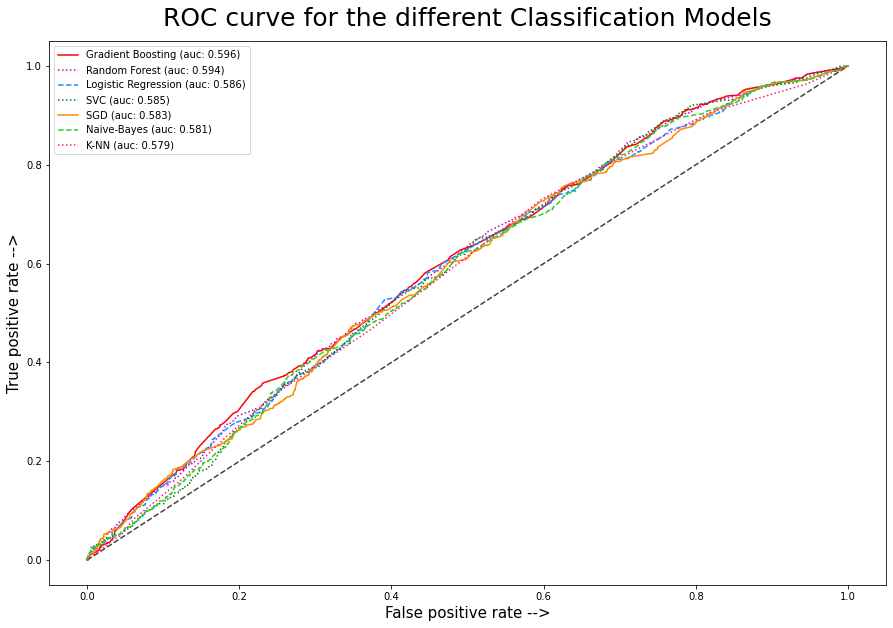

In [32]:
## We plot the ROC and AUC 
names = ["Gradient Boosting","Random Forest","Logistic Regression","SVC","SGD","Naive-Bayes","K-NN"]
clfs = [gbc_best,rfc_best,best_lreg,svc_best,sgd_best,nb_best,knn_best]

## Parameters for the plotting 
linestyles =['-',':','--',':','-','--',':']
colors = ['r','m','dodgerblue','g','darkorange','limegreen', 'deeppink']

plt.figure(figsize=(15,10))
counter = 0
for name,clf in zip(names,clfs):
    clf.fit(X_train,y_train)
    y_proba = clf.predict_proba(X_test)[:,1]
    #print("Roc AUC:"+name, roc_auc_score(y_test, clf.predict_proba(X_test)[:,1],average='macro')) ## Can uncomment
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=name+ ' (auc: %0.3f)' %roc_auc_score(y_test, clf.predict_proba(X_test)[:,1],average='macro'),
             linestyle=linestyles[counter], c=colors[counter])
    counter += 1
## Plot a straight line that goes throug
lims = [np.min([0.0, 0.0]),  np.max([1.0, 1.0])]
plt.plot(lims, lims, 'k-', alpha=0.75, zorder=0, c='black', linestyle ='--')

plt.xlabel('False positive rate -->', fontsize = 15)
plt.ylabel('True positive rate -->', fontsize = 15)
plt.title('ROC curve for the different Classification Models', pad =15, fontsize = 25)
plt.legend(loc='best')
plt.savefig('roc_auc_classification.png')
plt.show()  